# Introduction to Altair: Composition (2/3)

When visualizing a number of different data fields, we might be tempted to use as many visual encoding channels as we can: `x`, `y`, `color`, `size`, `shape`, and so on. However, as the number of encoding channels increases, a chart can rapidly become cluttered and difficult to read. An alternative to "over-loading" a single chart is to instead _compose multiple charts_ in a way that facilitates rapid comparisons.

In this notebook, we will examine a variety of operations for _multi-view composition_:

- _layer_: place compatible charts directly on top of each other,
- _facet_: partition data into multiple charts, organized in rows or columns,
- _concatenate_: position arbitrary charts within a shared layout
- _repeat_: take a base chart specification and apply it to multiple data fields.

_This notebook is part of [the Vega-Lite + Altair Workshop at SDSS 2019](https://ww2.amstat.org/meetings/sdss/2019/onlineprogram/AbstractDetails.cfm?AbstractID=305112)._

_Acknowledgement:_ This series  of notebook-based workshop is an adaption from the University of Washington's [Data Visualization Curriculum](https://github.com/uwdata/visualization-curriculum), with examples from the [Vega-Lite presentation video from OpenVisConf 2017](https://www.youtube.com/watch?v=9uaHRWj04D4) for a short workshop (60-90 minutes).

# Import Libraries and Data

In [5]:
import pandas as pd
import altair as alt

Again, we will use the Seattle Weather data for this part of the tutorial. 

In [6]:
df = pd.read_csv('seattle-weather.csv')
df.head()

date  precipitation  temperature  wind  weather
0  2012/01/01            0.0         12.8   4.7  drizzle
1  2012/01/02           10.9         10.6   4.5     rain
2  2012/01/03            0.8         11.7   2.3     rain
3  2012/01/04           20.3         12.2   4.7     rain
4  2012/01/05            1.3          8.9   6.1     rain

## Facet

As we saw a `row`/`column` encoding in the previous notebook

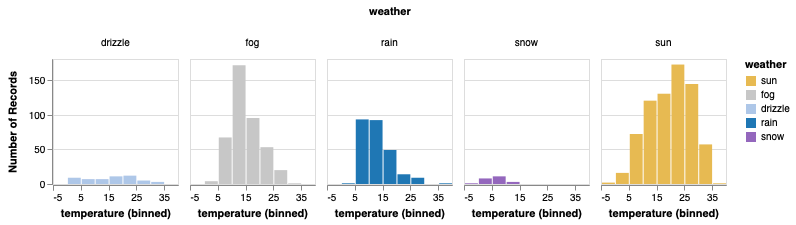

In [116]:
alt.Chart(df).mark_bar().encode(
  x=alt.X('temperature', bin=True), 
  y="count()", 
  color=alt.Color("weather", scale=alt.Scale(
    domain=["sun", "fog", "drizzle", "rain", "snow"],
    range=["#e7ba52", "#c7c7c7", "#aec7e8", "#1f77b4", "#9467bd"]
  )),
  column="weather"
).properties(width=125,height=125)

This is in fact a short cut for a `facet` composition method.

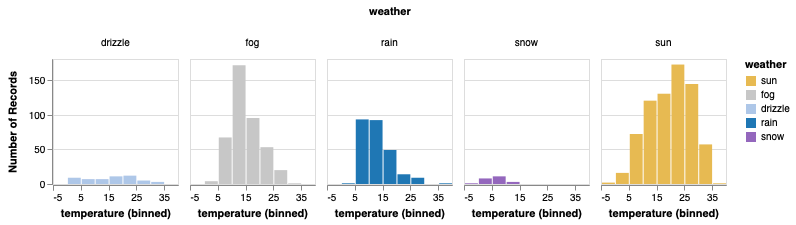

In [71]:
alt.Chart(df).mark_bar().encode(
  x=alt.X('temperature', bin=True), 
  y="count()", 
  color=alt.Color("weather", scale=alt.Scale(
    domain=["sun", "fog", "drizzle", "rain", "snow"],
    range=["#e7ba52", "#c7c7c7", "#aec7e8", "#1f77b4", "#9467bd"]
  ))
).properties(
  width=125,height=125
).facet(column="weather")

## Layer

One of the most common ways of combining multiple charts is to *layer* marks on top of each other.

For example, we can create a charrt showing monthly mean of precipitation with a line showing overall mean across the year.

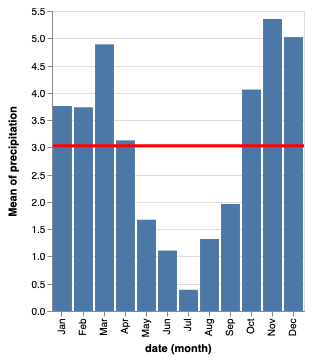

In [60]:
alt.Chart(df).mark_bar().encode(x="month(date):O", y="mean(precipitation)") + alt.Chart(df).mark_rule(color="red", size=3).encode(y="mean(precipitation)")

We will start from a plot showing monthly precipitation.

Note that we can assign a Chart object to a variable and call it to display. 

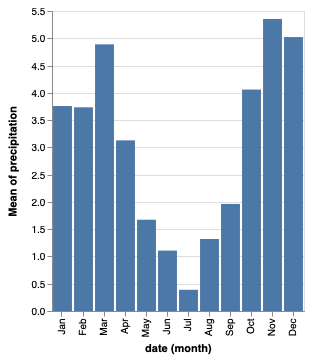

In [36]:
monthly_precip = alt.Chart(df).mark_bar().encode(x="month(date):O", y="mean(precipitation)")
monthly_precip

If we want to add a layer showing overall mean for any month, we can make another plot with a rule mark and without x-encoding.

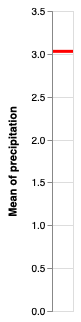

In [28]:
overall_precip = alt.Chart(df).mark_rule(color="red", size=3).encode(y="mean(precipitation)")
overall_precip

We can then combine the two plots with `+` operator to layer plots.  

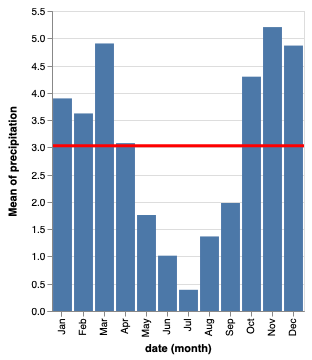

In [29]:
monthly_precip + overall_precip

This `+` operator is a short form of the `alt.layer()` method. 

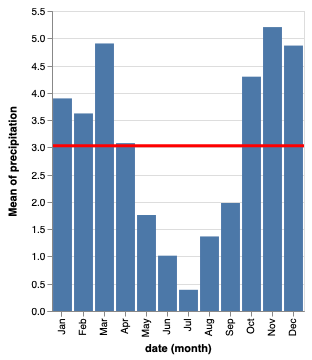

## Concatenate

Instead of layering overall precipitation mean, we can concatenate a plot of monthly temperature instead like this

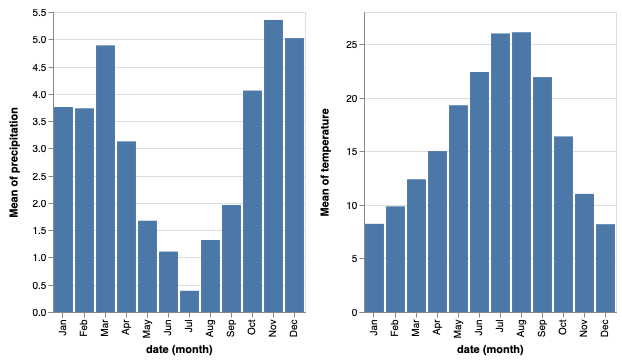

In [62]:
monthly_precip | alt.Chart(df).mark_bar().encode(x="month(date):O", y="mean(temperature)")

First, we can declare the monthly temperature plot.

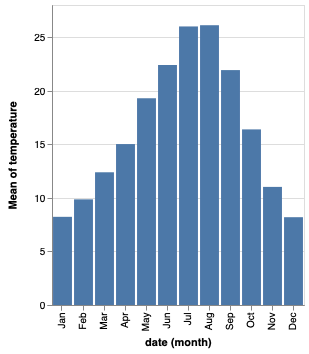

In [38]:
monthly_temp = alt.Chart(df).mark_bar().encode(x="month(date):O", y="mean(temperature)")
monthly_temp

We can then use the `&` operator as a shortcut for `alt.vconcat()` (vertical concat) or `|` for `alt.hconcat()` (horizontal concat)

## Repeat

A recurring pattern  is that many of the concatenated plots are the same chart with different fields. 
Thus, we also provide the `repeat` operator as a convenient shortcut for this common case. 

Let's recreate our concatenation example above using the `repeat` operator: 

- To create a template specification, we can use the *repeater variable* `alt.repeat('column')` as our y-axis field. This code simply states that we want to use the variable assigned to the `column` repeater, which organizes repeated charts in a horizontal direction. (As the repeater provides the field name only, we have to specify the field data type separately as `type='quantitative'`.)

- We then invoke the `repeat` method, passing in data field names for each column

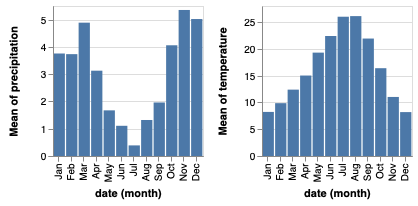

In [46]:
alt.Chart(df).mark_bar().encode(
    x="month(date):O", 
    y=alt.Y(alt.repeat('column'), aggregate="mean", type="quantitative")
).properties(
    width=150, height=150
).repeat(
    column=['precipitation', 'temperature']
)

We can easily add another quantitative variable such as "wind":

Or take it further to create a scatter plot matrix like this one below:

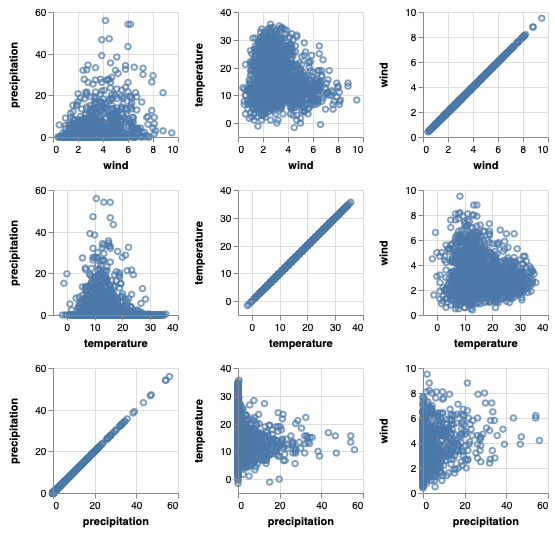

In [104]:
alt.Chart(df).mark_point().encode(
    x=alt.X(alt.repeat('row'), type="quantitative"),
    y=alt.Y(alt.repeat('column'), type="quantitative")
).properties(
    width=125, height=125
).repeat(
    column=['precipitation', 'temperature', 'wind'],
    row=['wind', 'temperature', 'precipitation']
)

In [65]:
# TODO: add scatterplot matrix


## A View Composition Algebra

Together, the composition operators `layer`, `facet`, `concat`, and `repeat` form a *view composition algebra*: the various operators can be combined to construct a variety of multi-view visualizations.



### Repeat of Layer


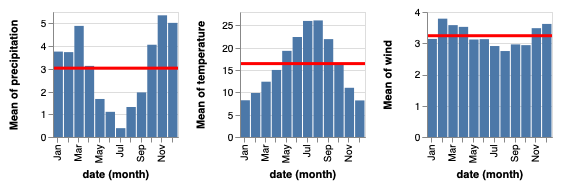

In [98]:
alt.layer(
    alt.Chart(df).mark_bar().encode(
        x="month(date):O", 
        y=alt.Y(alt.repeat('column'), aggregate='mean', type='quantitative')
    ),
    alt.Chart(df).mark_rule(color="red", size=3).encode(
        y=alt.Y(alt.repeat('column'), aggregate='mean', type='quantitative')
    )
).properties(width=125, height=125).repeat(
    column=['precipitation', 'temperature', 'wind']
)


Let's start from the layer chart that we had

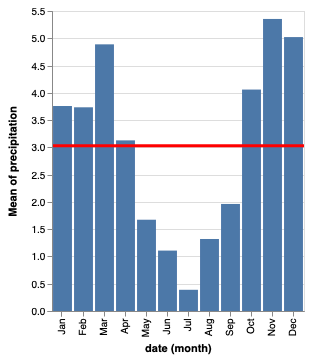

In [12]:
alt.layer(
    alt.Chart(df).mark_bar().encode(
        x="month(date):O", 
        y="mean(precipitation)"
    ), 
    alt.Chart(df).mark_rule(color="red", size=3).encode(
        y="mean(precipitation)"
    )
)

Now let's add repeat and adjust the size a bit

### Putting Them All Together!

So let's try to assign three views that we created earlier to variables and put them together!

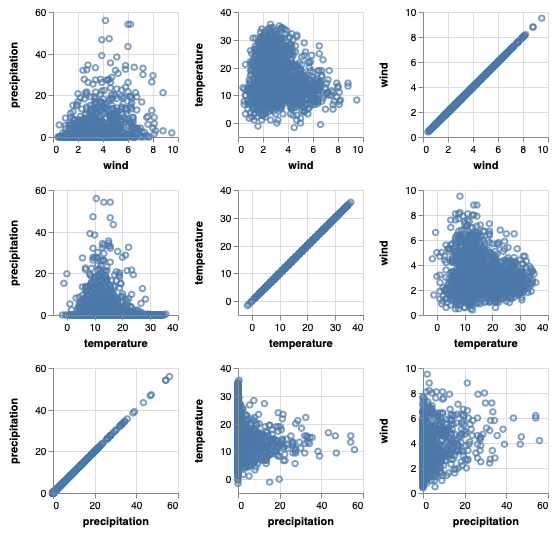

In [7]:
splom = alt.Chart(df).mark_point().encode(
    x=alt.X(alt.repeat('row'), type="quantitative"),
    y=alt.Y(alt.repeat('column'), type="quantitative")
).properties(
    width=125, height=125
).repeat(
    column=['precipitation', 'temperature', 'wind'],
    row=['wind', 'temperature', 'precipitation']
)
splom

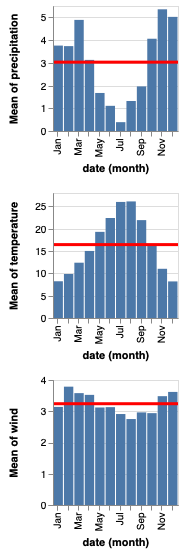

In [8]:
repeated = alt.layer(
    alt.Chart(df).mark_bar().encode(
        x="month(date):O", 
        y=alt.Y(alt.repeat('row'), aggregate='mean', type='quantitative')
    ),
    alt.Chart(df).mark_rule(color="red", size=3).encode(
        y=alt.Y(alt.repeat('row'), aggregate='mean', type='quantitative')
    )
).properties(width=125, height=125).repeat(
    row=['precipitation', 'temperature', 'wind']
)
repeated

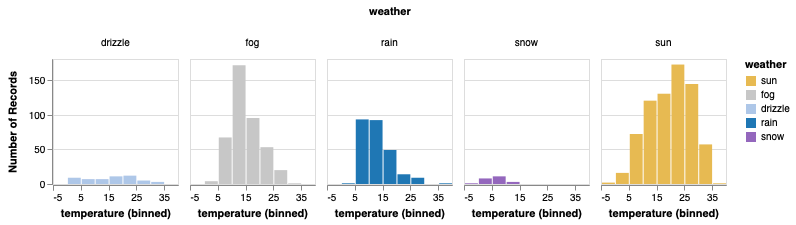

In [9]:
faceted = alt.Chart(df).mark_bar().encode(
  x=alt.X('temperature', bin=True), 
  y="count()", 
  color=alt.Color("weather", scale=alt.Scale(
    domain=["sun", "fog", "drizzle", "rain", "snow"],
    range=["#e7ba52", "#c7c7c7", "#aec7e8", "#1f77b4", "#9467bd"]
  ))
).properties(
  width=125,height=125
).facet(column="weather")

faceted

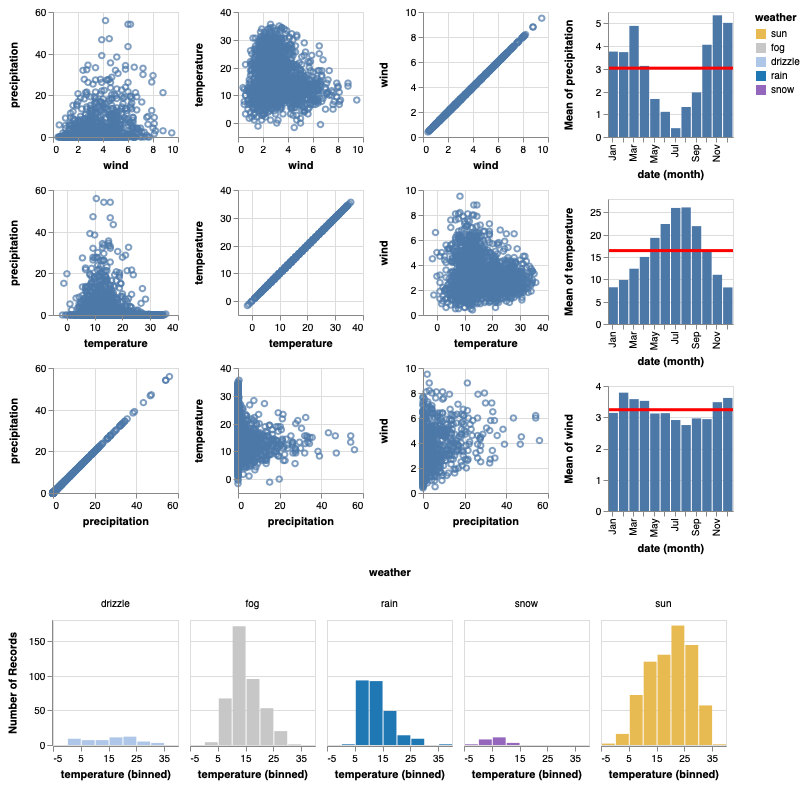

In [10]:
(splom | repeated) & faceted 

The full composition model for this dashboard is:

```
vconcat
|- hconcat
|  |- repeat(row=[...], column=[...])
|  |  |- splom base chart
|  |- repeat(row=[...])
|     |- layer
|        |- dateHist base chart 1
|        |- dateHist base chart 2
|- facet(column='weather')
   |- tempHist base chart
```

## Summary & Additional Resources

Now, we've learn how to compose multi-view charts in Vega-Lite.

You may also want to consult the [Altair interactive selection documentation](https://altair-viz.github.io) for more information about the language.